# 분류 예측의 불확실성 추정
* scikit-learn에서 많이 사용하는 인터페이스 중 하나이는 분류기에 예측의 불확실성을 추정할 수 있는 기능임
* scikit-learn에서 분류기의 불확실성을 추정할 수 있는 함수는 **decision_function**과 **predict_proba** 가 있음
* 대부분의 scikit-learn의 분류기에 위의 두 함수 중 하나 이상을 제공함

In [2]:
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# 예제를 위해 클래스의 이름을 'blue'와 'red'로 바꿈
y_named = np.array(["blue", "red"])[y]

# 여러 배열을 한번에 train_test_split에 넣을 수 있음
# training set와 test set으로 나뉘는 방식은 모두 같음
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)
    
# GradientBoosting 모델을 만듦
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

## 1. `decision_function` (결정 함수)

* scikit-learn에서 이진 분류의 decision_function의 return 값의 크기는 `(n_samples,)` 이며 각 샘플이 하나의 실수 값을 return한다.

In [4]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


* `decision_function` 의 결과값은 데이터 포인트가 양성 클래스인 클래스 1에 속한다고 믿는 정도를 나타냄 양수 값은 양성 클래스를 의미 음수값은 음수, 즉 다른 클래스를 의미함

In [5]:
# decision_function 결과 중 앞의 6개만 확인
print('Decision function:\n{}'.format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


In [6]:
print("Thresholded decision function:\n{}".format(gbrt.decision_function(X_test)[:6] > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)[:6]))

Thresholded decision function:
[ True False False False  True  True]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red']


* scikit-learn의 이진분류에서 음성 클래스는 항상 `classes_` 속성값의 첫 번째 원소이고 양성클래스는 `classes_`의 두 번째 원소임

In [8]:
# boolean 값을 0 과 1로 변환
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# classes_에 index로 사용
pred = gbrt.classes_[greater_zero]
# pred와 gbrt.predict의 결과를 비교
print('pred는 예측 결과와 같다: {}'.format(np.all(pred == gbrt.predict(X_test))))

pred는 예측 결과와 같다: True


* `decision_function` 값의 범위는 데이터와 모델 파라미터에 따라 달라짐

In [9]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


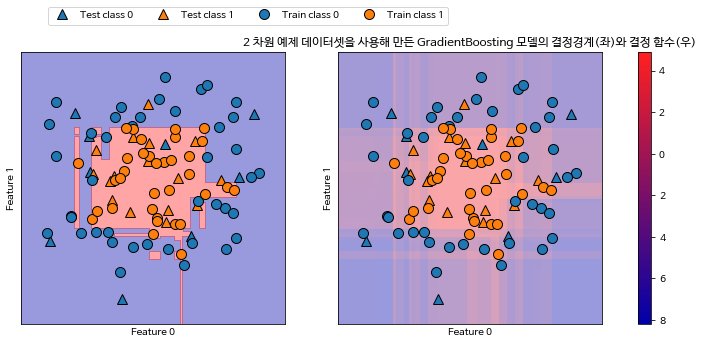

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)
plt.title("2 차원 예제 데이터셋을 사용해 만든 GradientBoosting 모델의 결정경계(좌)와 결정 함수(우)")
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

* 위의 그림을 통해 예측한 결과 뿐만 아니라 분류기가 얼마나 확신하는지에 대한 추가정보를 얻을 수 있음 

## 2. `predict_proba` (예측 확률)
* `predict_proba`의 출력은 각 클래스에 대한 확률이다. 출력값의 크기는 이진 분류에서는 항상 `(n_samples, 2)`이다.

In [14]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


* 각 행의 첫 번째 원소는 첫 번째 클래스의 예측 확률이고, 두 번째 원소는 두 번째 클래스의 예측 확률이다. 두 값의 합은 항상 1이 된다.
* 둘 중 높은 확률값을 가지는 쪽의 클래스로 분류된다.
* 아래의 코드에서 확인할 수 있듯이, `decision_function`보다 이해하기가 쉽다.

In [15]:
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(
    gbrt.predict_proba(X_test[:6])))

Predicted probabilities:
[[ 0.01573626  0.98426374]
 [ 0.84575649  0.15424351]
 [ 0.98112869  0.01887131]
 [ 0.97406775  0.02593225]
 [ 0.01352142  0.98647858]
 [ 0.02504637  0.97495363]]


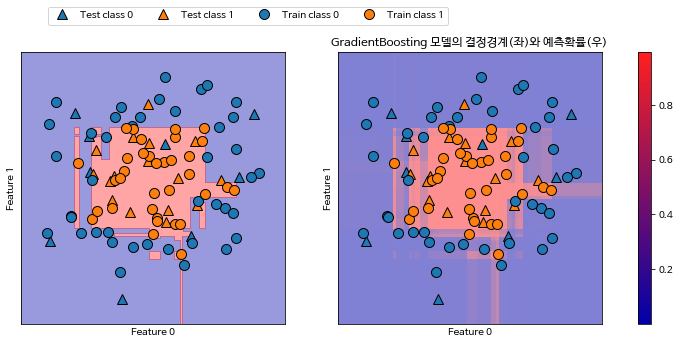

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

plt.title("GradientBoosting 모델의 결정경계(좌)와 예측확률(우)")
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# don't want a transparent colorbar
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

## 3. Uncertainty in multi-class classification (다중 분류에서의 불확실성)
* scikit-learn의 `decision_function`과 `predict_proba` 함수는 다중 분류에서도 사용할 수 있음

In [18]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

* `decision_function` 이용
* 다중분류에서의 `decision_function`의 결과값은 `(n_samples, n_classes)`이다.
* 각 열은 각 클래스에 대한 확신 점수(?)를 나타냄

In [19]:
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# plot the first few entries of the decision function
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function:
[[-0.52931069  1.46560359 -0.50448467]
 [ 1.51154215 -0.49561142 -0.50310736]
 [-0.52379401 -0.4676268   1.51953786]
 [-0.52931069  1.46560359 -0.50448467]
 [-0.53107259  1.28190451  0.21510024]
 [ 1.51154215 -0.49561142 -0.50310736]]


In [21]:
print("Argmax of decision function:\n{}".format(
    np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


* `predict_proba`의 출력값 크기는 `(n_samples, n_classes)`로 decision_function 출력값의 크기와 같다.

In [22]:
# show the first few entries of predict_proba
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# show that sums across rows are one
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[ 0.10664722  0.7840248   0.10932798]
 [ 0.78880668  0.10599243  0.10520089]
 [ 0.10231173  0.10822274  0.78946553]
 [ 0.10664722  0.7840248   0.10932798]
 [ 0.10825347  0.66344934  0.22829719]
 [ 0.78880668  0.10599243  0.10520089]]
Sums: [ 1.  1.  1.  1.  1.  1.]


In [23]:
print("Argmax of predicted probabilities:\n{}".format(
    np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
